In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 200

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 340

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

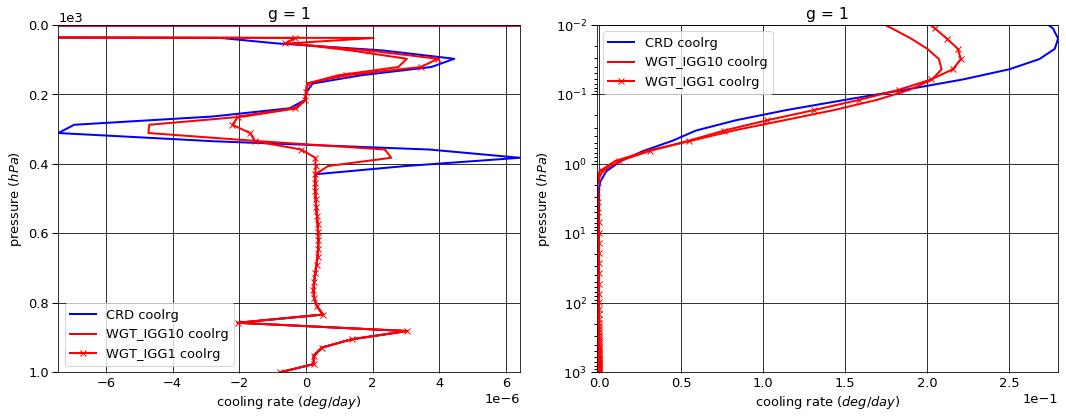

# Figure: cooling rate g-group 2

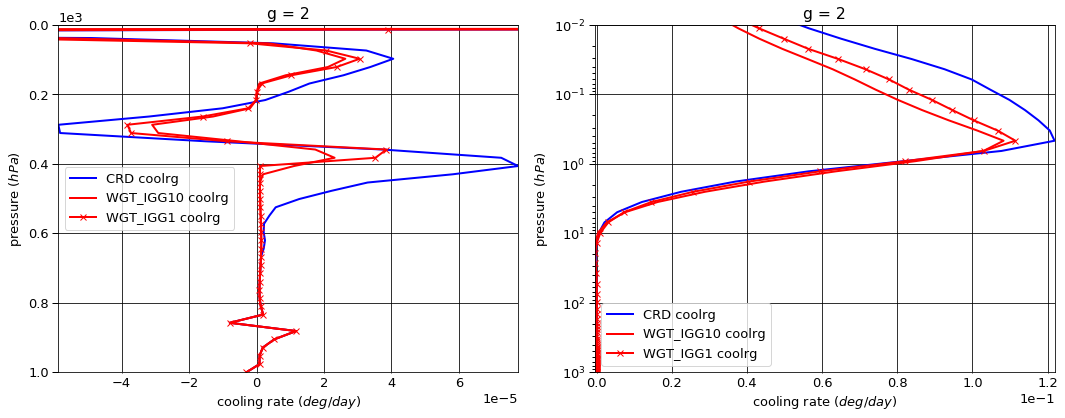

# Figure: cooling rate g-group 3

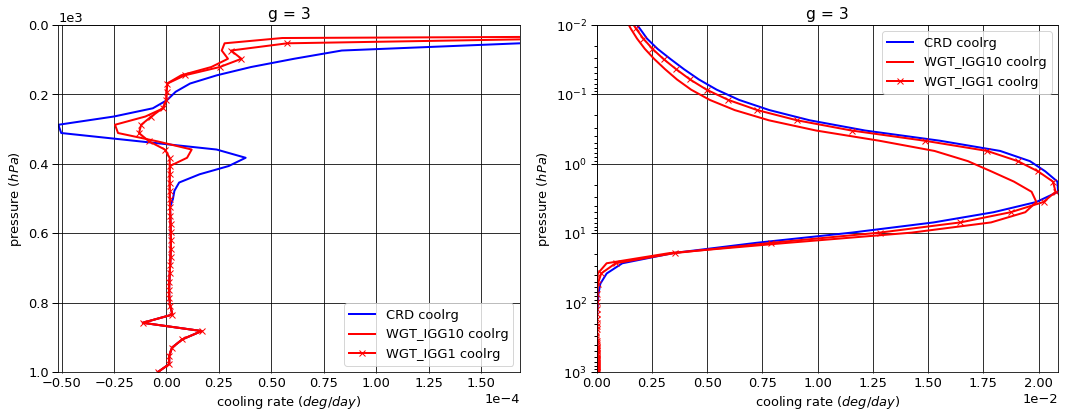

# Figure: cooling rate g-group 4

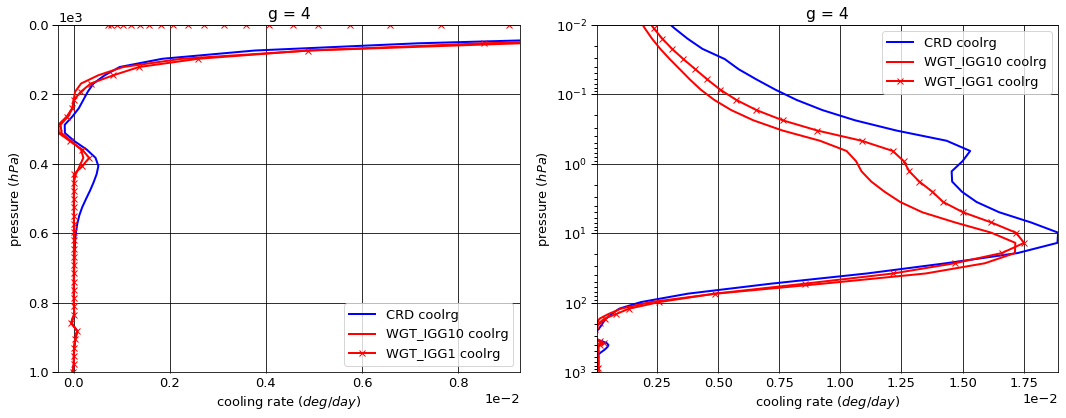

# Figure: cooling rate g-group 5

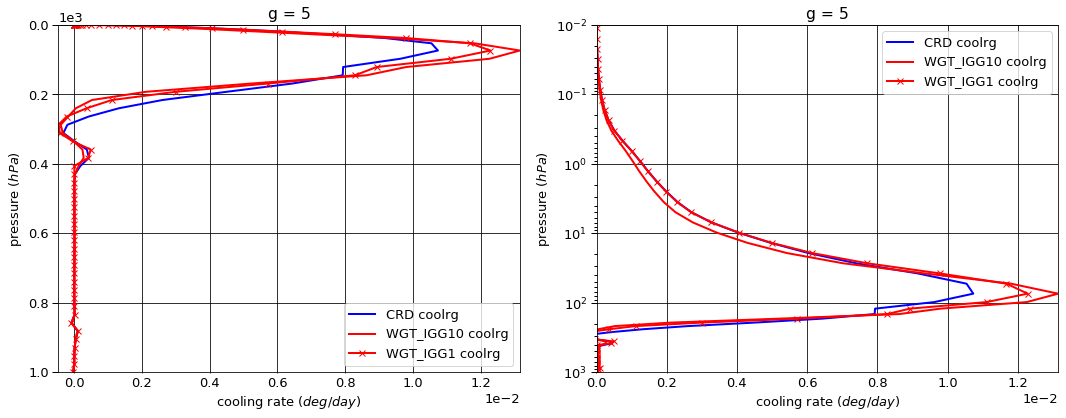

# Figure: cooling rate g-group 6

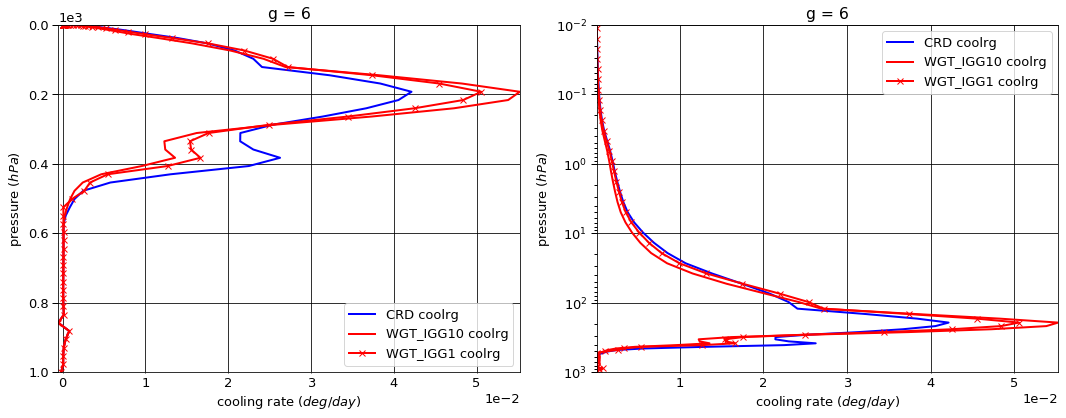

# Figure: cooling rate g-group 7

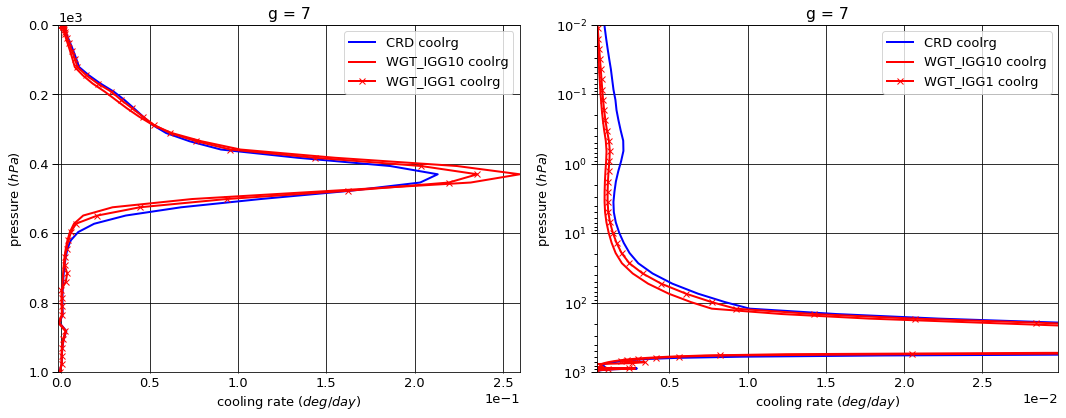

# Figure: cooling rate g-group 8

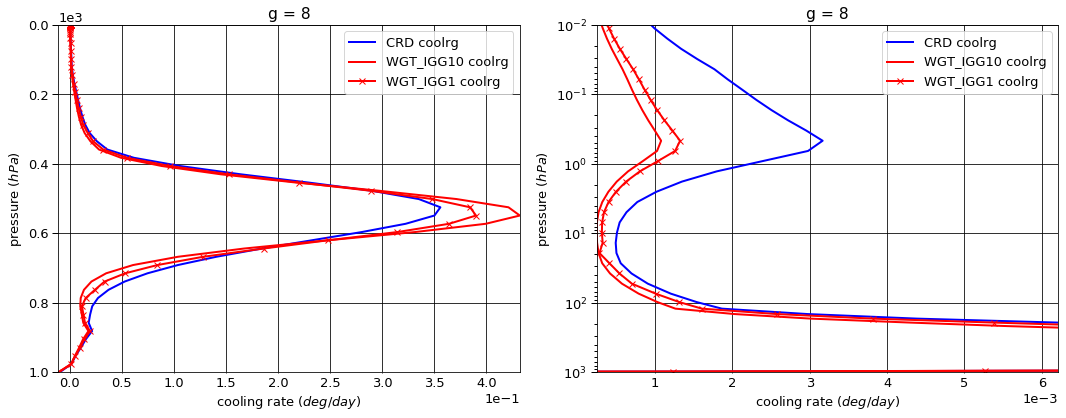

# Figure: cooling rate g-group 9

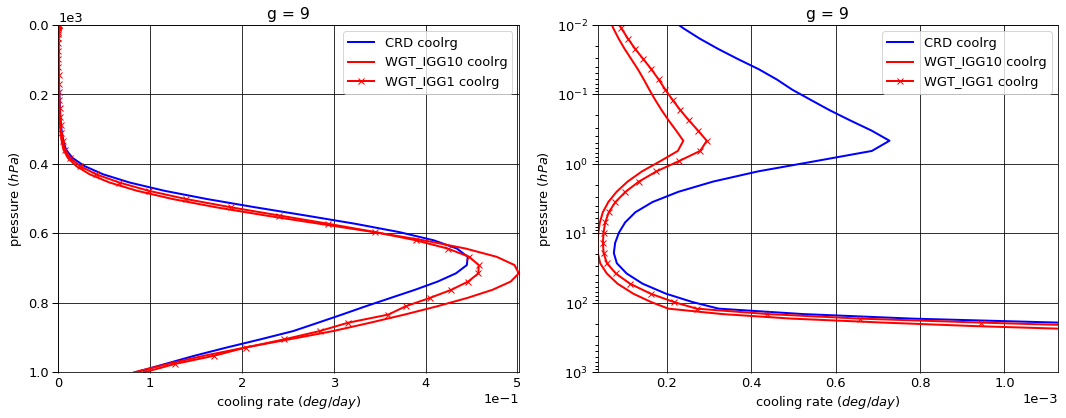

# Figure: cooling rate g-group 10

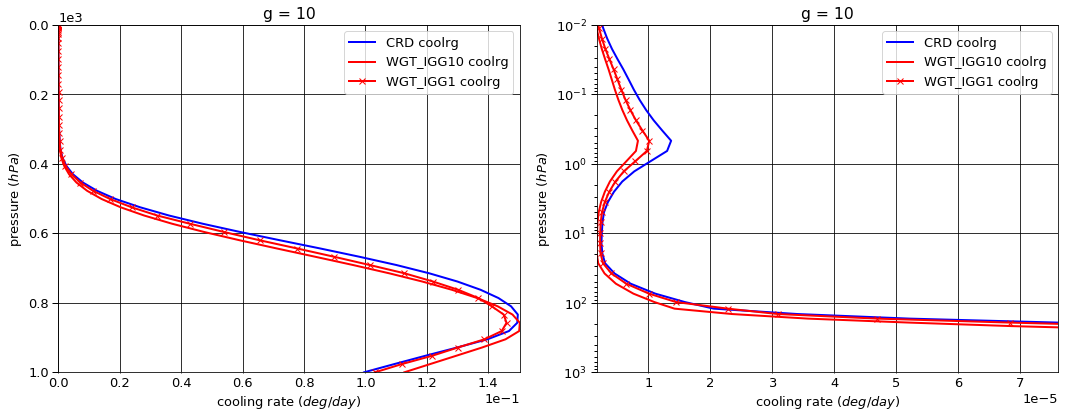

# Figure: cooling rate g-group total

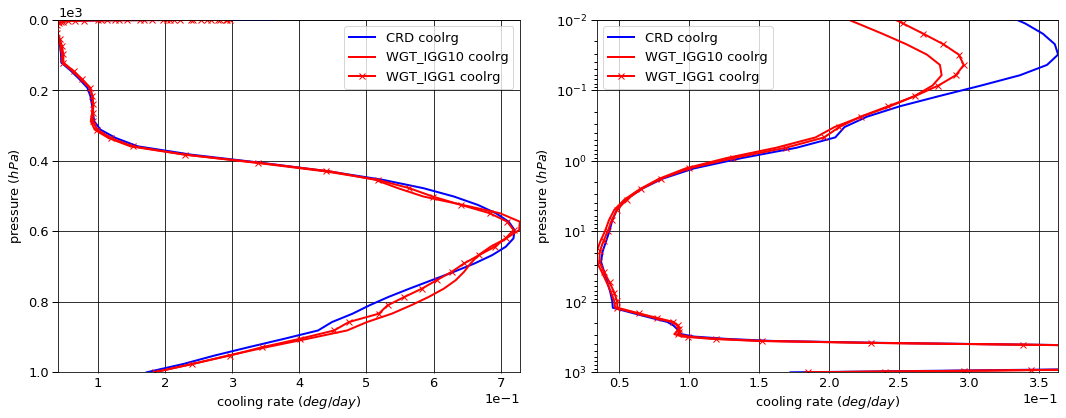

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007705   0.000000  -0.007705
   1013.0   76     -0.008381   0.008383   0.000003
2  0.0      1      -0.024875   0.000000  -0.024875
   1013.0   76     -0.030246   0.030257   0.000010
3  0.0      1      -0.031037   0.000000  -0.031037
   1013.0   76     -0.045755   0.045769   0.000015
4  0.0      1      -0.124885   0.000000  -0.124885
   1013.0   76     -0.198055   0.198143   0.000088
5  0.0      1      -0.202430   0.000000  -0.202430
   1013.0   76     -0.315301   0.315399   0.000098
6  0.0      1      -1.365637   0.000000  -1.365637
   1013.0   76     -2.111880   2.112572   0.000691
7  0.0      1      -4.693923   0.000000  -4.693923
   1013.0   76     -6.441182   6.445077   0.003895
8  0.0      1     -10.076164   0.000000 -10.076164
   1013.0   76    -12.035827  12.089692   0.053866
9  0.0      1     -21.485534   0.000000 -21.485534
   1013.0   76    -22.888909  20.893913  -1.994996
10 0.0      1     -13.901474   0.000000 -13.901474
   1013.0   76    -14.107994   6.707580  -7.400414


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007866   0.000000  -0.007866
   1013.0   76     -0.008381   0.008383   0.000003
2  0.0      1      -0.024823   0.000000  -0.024823
   1013.0   76     -0.030246   0.030257   0.000010
3  0.0      1      -0.030969   0.000000  -0.030969
   1013.0   76     -0.045755   0.045769   0.000015
4  0.0      1      -0.122783   0.000000  -0.122783
   1013.0   76     -0.198055   0.198120   0.000065
5  0.0      1      -0.202161   0.000000  -0.202161
   1013.0   76     -0.315301   0.315399   0.000098
6  0.0      1      -1.346442   0.000000  -1.346442
   1013.0   76     -2.111880   2.112572   0.000691
7  0.0      1      -4.659056   0.000000  -4.659056
   1013.0   76     -6.441182   6.444742   0.003561
8  0.0      1     -10.058294   0.000000 -10.058294
   1013.0   76    -12.035827  12.084862   0.049035
9  0.0      1     -21.629993   0.000000 -21.629993
   1013.0   76    -22.888909  21.948098  -0.940811
10 0.0      1     -13.946158   0.000000 -13.946158
   1013.0   76    -14.107994   6.385007  -7.722987


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007833   0.000000  -0.007833
   1013.0   76     -0.008381   0.008383   0.000003
2  0.0      1      -0.024720   0.000000  -0.024720
   1013.0   76     -0.030246   0.030257   0.000010
3  0.0      1      -0.031066   0.000000  -0.031066
   1013.0   76     -0.045755   0.045769   0.000015
4  0.0      1      -0.123249   0.000000  -0.123249
   1013.0   76     -0.198055   0.198120   0.000065
5  0.0      1      -0.202156   0.000000  -0.202156
   1013.0   76     -0.315301   0.315399   0.000098
6  0.0      1      -1.350021   0.000000  -1.350021
   1013.0   76     -2.111880   2.112572   0.000691
7  0.0      1      -4.667346   0.000000  -4.667346
   1013.0   76     -6.441182   6.443284   0.002102
8  0.0      1     -10.064239   0.000000 -10.064239
   1013.0   76    -12.035827  12.089862   0.054036
9  0.0      1     -21.586589   0.000000 -21.586589
   1013.0   76    -22.888909  21.317132  -1.571777
10 0.0      1     -13.918071   0.000000 -13.918071
   1013.0   76    -14.107994   6.433654  -7.674340


WGT_IGG10 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -1.613689e-04  0.000000e+00 -1.613689e-04
   1013.0   76     0.000000e+00  0.000000e+00  4.235165e-22
2  0.0      1      5.239300e-05  0.000000e+00  5.239300e-05
   1013.0   76     3.469447e-18  3.469447e-18  0.000000e+00
3  0.0      1      6.810900e-05  0.000000e+00  6.810900e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      2.101510e-03  0.000000e+00  2.101510e-03
   1013.0   76     0.000000e+00 -2.360000e-05 -2.359390e-05
5  0.0      1      2.688600e-04  0.000000e+00  2.688600e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      1.919480e-02  0.000000e+00  1.919480e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      3.486710e-02  0.000000e+00  3.486710e-02
   1013.0   76     0.000000e+00 -3.347000e-04 -3.347060e-04
8  0.0      1      1.787000e-02  0.000000e+00  1.787000e-02
   1013.0   76     1.776357e-15 -4.830000e-03 -4.830469e-03
9  0.0      1     -1.444590e-01  0.000000e+00 -1.444590e-01
   1013.0   76    -3.552714e-15  1.054185e+00  1.054185e+00
10 0.0      1     -4.468400e-02  0.000000e+00 -4.468400e-02
   1013.0   76     0.000000e+00 -3.225729e-01 -3.225729e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g  pressure level                                          
1  0.0      1     -1.283913e-04  0.000000e+00 -1.283913e-04
   1013.0   76     0.000000e+00  0.000000e+00  4.235165e-22
2  0.0      1      1.548500e-04  0.000000e+00  1.548500e-04
   1013.0   76     3.469447e-18  3.469447e-18  0.000000e+00
3  0.0      1     -2.923700e-05  0.000000e+00 -2.923700e-05
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
4  0.0      1      1.635990e-03  0.000000e+00  1.635990e-03
   1013.0   76     0.000000e+00 -2.360000e-05 -2.359390e-05
5  0.0      1      2.740300e-04  0.000000e+00  2.740300e-04
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
6  0.0      1      1.561620e-02  0.000000e+00  1.561620e-02
   1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
7  0.0      1      2.657720e-02  0.000000e+00  2.657720e-02
   1013.0   76     0.000000e+00 -1.793200e-03 -1.793201e-03
8  0.0      1      1.192500e-02  0.000000e+00  1.192500e-02
   1013.0   76     1.776357e-15  1.700000e-04  1.697750e-04
9  0.0      1     -1.010550e-01  0.000000e+00 -1.010550e-01
   1013.0   76    -3.552714e-15  4.232190e-01  4.232197e-01
10 0.0      1     -1.659700e-02  0.000000e+00 -1.659700e-02
   1013.0   76     0.000000e+00 -2.739259e-01 -2.739258e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.467273e-01
   1001.112500 75    -7.734623e-07
2  0.000312    1      1.189092e-02
   1001.112500 75    -2.989462e-06
3  0.000312    1      3.645287e-04
   1001.112500 75    -4.276290e-06
4  0.000312    1      8.311864e-04
   1001.112500 75    -2.448117e-05
5  0.000312    1      4.071431e-07
   1001.112500 75    -2.843919e-05
6  0.000312    1      3.255486e-05
   1001.112500 75    -2.008763e-04
7  0.000312    1      3.657381e-04
   1001.112500 75    -1.100197e-03
8  0.000312    1      2.526567e-04
   1001.112500 75    -9.849131e-03
9  0.000312    1      5.217998e-05
   1001.112500 75     8.419131e-02
10 0.000312    1      1.926108e-07
   1001.112500 75     9.957007e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      6.932892e-02
   1001.112500 75    -7.734623e-07
2  0.000312    1      9.731426e-03
   1001.112500 75    -2.989462e-06
3  0.000312    1      3.479218e-04
   1001.112500 75    -4.276290e-06
4  0.000312    1      6.185732e-04
   1001.112500 75    -1.886402e-05
5  0.000312    1      3.379158e-07
   1001.112500 75    -2.843919e-05
6  0.000312    1      2.352971e-05
   1001.112500 75    -2.008763e-04
7  0.000312    1      1.378830e-04
   1001.112500 75    -1.015935e-03
8  0.000312    1      7.696053e-05
   1001.112500 75    -1.085798e-02
9  0.000312    1      1.334005e-05
   1001.112500 75     8.242333e-02
10 0.000312    1      1.216186e-07
   1001.112500 75     1.126783e-01


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      9.214623e-02
   1001.112500 75    -7.734623e-07
2  0.000312    1      1.054805e-02
   1001.112500 75    -2.989462e-06
3  0.000312    1      3.894225e-04
   1001.112500 75    -4.276290e-06
4  0.000312    1      7.238616e-04
   1001.112500 75    -1.886402e-05
5  0.000312    1      4.065667e-07
   1001.112500 75    -2.843919e-05
6  0.000312    1      2.835316e-05
   1001.112500 75    -2.008763e-04
7  0.000312    1      1.721690e-04
   1001.112500 75    -6.111393e-04
8  0.000312    1      1.002620e-04
   1001.112500 75    -1.104063e-02
9  0.000312    1      1.866499e-05
   1001.112500 75     9.360963e-02
10 0.000312    1      1.770002e-07
   1001.112500 75     1.031753e-01


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -7.739836e-02
   1001.112500 75    -1.058791e-22
2  0.000312    1     -2.159492e-03
   1001.112500 75     4.235165e-22
3  0.000312    1     -1.660688e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.126132e-04
   1001.112500 75     5.617153e-06
5  0.000312    1     -6.922737e-08
   1001.112500 75    -3.388132e-21
6  0.000312    1     -9.025150e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -2.278551e-04
   1001.112500 75     8.426170e-05
8  0.000312    1     -1.756961e-04
   1001.112500 75    -1.008852e-03
9  0.000312    1     -3.883993e-05
   1001.112500 75    -1.767983e-03
10 0.000312    1     -7.099219e-08
   1001.112500 75     1.310819e-02


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -5.458105e-02
   1001.112500 75    -1.058791e-22
2  0.000312    1     -1.342867e-03
   1001.112500 75     4.235165e-22
3  0.000312    1      2.489376e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -1.073249e-04
   1001.112500 75     5.617153e-06
5  0.000312    1     -5.763900e-10
   1001.112500 75    -3.388132e-21
6  0.000312    1     -4.201701e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -1.935691e-04
   1001.112500 75     4.890577e-04
8  0.000312    1     -1.523947e-04
   1001.112500 75    -1.191502e-03
9  0.000312    1     -3.351499e-05
   1001.112500 75     9.418324e-03
10 0.000312    1     -1.561059e-08
   1001.112500 75     3.605251e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.913663,0.000000,-51.913663
1013.0,76,-58.183530,48.846786,-9.336744



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-52.028544,0.000000,-52.028544
1013.0,76,-58.183530,49.573209,-8.610321



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-51.975289,0.000000,-51.975289
1013.0,76,-58.183530,48.994432,-9.189097



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.114882,0.000000,-0.114882
1013.0,76,0.000000,0.726424,0.726423



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.061626,0.000000,-0.061626
1013.0,76,0.000000,0.147646,0.147647


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.160518
1001.112500,75,0.172550



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.080279
1001.112500,75,0.182971



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.104128
1001.112500,75,0.184877



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.080239
1001.112500,75,0.010421



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.056390
1001.112500,75,0.012327


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000150,0.000145
2,0.000525,0.000521
3,0.000825,0.000792
4,0.003525,0.003422
5,0.005775,0.005468
6,0.037575,0.036493
7,0.114900,0.111318
8,0.211525,0.207564
9,0.390375,0.393311


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.384515e-18
2,5.623149e-19
3,4.227122e-19
4,4.626733e-20
5,1.509806e-19
6,1.832682e-20
7,2.224606e-21
8,2.700344e-22
9,3.277820e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.384515e-18,NaN,0.000150,0.000145,0.000150,0.000145,1.0
2,5.623149e-19,0.104432,0.000525,0.000521,0.000675,0.000666,1.0
3,4.227122e-19,0.751736,0.000825,0.000792,0.001500,0.001458,10.0
4,4.626733e-20,0.109454,0.003525,0.003422,0.005025,0.004880,10.0
5,1.509806e-19,3.263222,0.005775,0.005468,0.010800,0.010347,500.0
6,1.832682e-20,0.121385,0.037575,0.036493,0.048375,0.046840,500.0
7,2.224606e-21,0.121385,0.114900,0.111318,0.163275,0.158159,500.0
8,2.700344e-22,0.121385,0.211525,0.207564,0.374800,0.365723,500.0
9,3.277820e-23,0.121385,0.390375,0.393311,0.765175,0.759034,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     2.436465e-17  1.216599e-17   2.002685  1.451611e-03
      2  0.000312     7.345923e-19  3.624123e-19   2.026952  4.354156e-05
      3  0.000312     8.217713e-21  7.521843e-21   1.092513  6.642732e-07
      4  0.000312     3.996120e-21  2.246149e-21   1.779098  2.508964e-07
      5  0.000312     9.882329e-25  9.878184e-25   1.000420  8.413787e-11
      6  0.000312     1.259774e-23  9.666052e-24   1.303297  9.230383e-10
      7  0.000312     5.309174e-23  5.742086e-24   9.246071  2.101943e-09
      8  0.000312     2.416199e-23  1.201205e-24  20.114798  8.844425e-10
      9  0.000312     4.042321e-24  1.337755e-25  30.217207  1.445350e-10
      10 0.000312     7.107572e-26  1.435862e-26   4.950037  4.603862e-12
2     1  0.000750     2.451525e-17  1.223478e-17   2.003734  5.881715e-04
      2  0.000750     7.576551e-19  3.749980e-19   2.020424  1.811343e-05
      3  0.000750     8.700455e-21  7.942797e-21   1.095389  2.828476e-07
      4  0.000750     4.164451e-21  2.317189e-21   1.797199  1.048294e-07
      5  0.000750     1.408080e-24  1.407603e-24   1.000339  4.828982e-11
      6  0.000750     1.312070e-23  1.001854e-23   1.309643  3.862174e-10
      7  0.000750     5.382826e-23  5.870101e-24   9.169904  8.593749e-10
      8  0.000750     2.503908e-23  1.221275e-24  20.502412  3.686891e-10
      9  0.000750     4.159607e-24  1.365262e-25  30.467462  5.988262e-11
      10 0.000750     7.418703e-26  1.472826e-26   5.037054  1.932884e-12
3     1  0.001052     2.481644e-17  1.237201e-17   2.005854  8.345994e-04
      2  0.001052     8.064263e-19  4.015697e-19   2.008185  2.710738e-05
      3  0.001052     9.704130e-21  8.805206e-21   1.102090  4.408653e-07
      4  0.001052     4.521872e-21  2.460694e-21   1.837641  1.580306e-07
      5  0.001052     1.807402e-24  1.806779e-24   1.000345  8.692585e-11
      6  0.001052     1.412183e-23  1.065124e-23   1.325838  5.791508e-10
      7  0.001052     5.536280e-23  6.125454e-24   9.038155  1.242073e-09
      8  0.001052     2.692842e-23  1.262174e-24  21.334955  5.545789e-10
      9  0.001052     4.409237e-24  1.420484e-25  31.040377  8.894123e-11
      10 0.001052     8.097816e-26  1.546341e-26   5.236760  2.949937e-12
4     1  0.001476     2.511360e-17  1.250812e-17   2.007783  1.184386e-03
      2  0.001476     8.591274e-19  4.303676e-19   1.996264  4.061739e-05
      3  0.001476     1.083731e-20  9.769523e-21   1.109297  6.881216e-07
      4  0.001476     4.918934e-21  2.614394e-21   1.881482  2.386417e-07
      5  0.001476     2.356657e-24  2.355842e-24   1.000346  1.590064e-10
      6  0.001476     1.522317e-23  1.134491e-23   1.341850  8.703031e-10
      7  0.001476     5.699669e-23  6.395371e-24   8.912179  1.797528e-09
      8  0.001476     2.901801e-23  1.306188e-24  22.215799  8.362031e-10
      9  0.001476     4.680766e-24  1.477744e-25  31.675082  1.323364e-10
      10 0.001476     8.864946e-26  1.621956e-26   5.465591  4.516140e-12
5     1  0.002070     2.540236e-17  1.264113e-17   2.009501  1.679691e-03
      2  0.002070     9.153921e-19  4.611576e-19   1.984987  6.084833e-05
      3  0.002070     1.210433e-20  1.083708e-20   1.116936  1.073751e-06
      4  0.002070     5.355468e-21  2.777087e-21   1.928448  3.604833e-07
      5  0.002070     3.117860e-24  3.116796e-24   1.000342  2.950569e-10
      6  0.002070     1.642995e-23  1.210714e-23   1.357046  1.309655e-09
      7  0.002070     5.871893e-23  6.676337e-24   8.795082  2.602352e-09
      8  0.002070     3.130432e-23  1.353085e-24  23.135523  1.262074e-09
      9  0.002070     4.973040e-24  1.536191e-25  32.372535  1.970113e-10
      10 0.002070     9.722508e-26  1.699436e-26   5.721019  6.924481e-12
6     1  0.002904     2.568216e-17  1.277077e-17   2.011010  2.381353e-03
      2  0.002904     9.754659e-19  4.940346e-19   1.974489  9.116389e-05
      3  0.002904     1.352492e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
